# IMPORTS

In [1]:
import pandas as pd
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, recall_score, precision_score, precision_recall_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split


# DATA EXPLAIN AND PREPARATION

Данные берем из этого датасета Kaggle https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction

### [!] DISCLAMER

В моем учебном примере стоит задача улучшения кредитного скоринга у банка-стартапа, то есть текущая ситуация говорит о том,  что дефолтящих клиентов достаточно много, так как используется эвристические методы для скоринга клиентов (по сути эфвристическое решающее дерево).

В самом датасете дефолтящих клиентов очень мало, меньше 1%, что не соответствует исходому состоянию и бизнес-задаче. Поэтому датасет будет немного модернизирован. Мы используем NearMiss метод андерсемплинга для majority класса на всем датасете и уберем из класса 0 объекты, которые находятся максимально далеко от объектов 1 класса.

Таким образорм мы:
- Нормализуем пропорцию до необходимой в бизнес-кейсе
- Не будем добавлять синтетические данные, а скорее уберем лишнее
- Уберем только те значения, в которых модель вероятно была бы более уверена, чем в оставшихся, при разделении

Далее случайным образом уберем часть 1 класса чтобы получить пропорцию 0.2

### Features

In [2]:
df = pd.read_csv('data/application_record.csv', sep=',')

In [3]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
df.shape

(438557, 18)

**Feature description** - https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/discussion/119320

### Target

#### Для скачивания таргета уже надо перейти на стрраницу Kaggle
https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/data?select=credit_record.csv

In [5]:
df_target = pd.read_csv('data/credit_record.csv', sep=',')

In [6]:
df_target.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [7]:
df_target.shape

(1048575, 3)

In [8]:
df_target['ID'].nunique()/len(df_target)

0.04385475526309515

**MONTHS_BALANCE** - The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on  

**STATUS** - 0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

### Выводы об исходных данных
0) Уникальных ID сильно меньше, чем самих записей.
1) Всего у нас почти 440к строк с записями о заемщиках.
2) Есть 18 базовых признаков заемщика таких как: зарплата, наличие недвижимости в собственности, налииче машины, возраст и др.
3) Старгетом интереснее, так как он не бинарный. У нас есть несколько групп пользоватлей по сроку просрочки платежа от 1 до 150+ дней. Также есть группа С, которая не просрочила платеж и группа Х, которая не брала займы и не платила по кредиту в этом месяце.

Для нашего упражнения попробуем бинаризовать таргет, так как для нас важно предсказывать дефолтящих клиентов с просрочкой более 90 дней. Получается в класс 1 попадут юзеры с тегами: 3, 4, 5; а в клсс 0 - остальные, кроме класса Х, так как они вообще не брали заем и таких пользователей мы не планируем скорить на проде.

# EDA

In [9]:
df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [10]:
# Видим константный признак FLAG_MOBIL, который точно не берем в обучение
df['FLAG_MOBIL'].value_counts()

FLAG_MOBIL
1    438557
Name: count, dtype: int64

In [11]:
df = df.drop(columns=['FLAG_MOBIL'])

In [12]:
df.isna().sum()/len(df)

ID                     0.00000
CODE_GENDER            0.00000
FLAG_OWN_CAR           0.00000
FLAG_OWN_REALTY        0.00000
CNT_CHILDREN           0.00000
AMT_INCOME_TOTAL       0.00000
NAME_INCOME_TYPE       0.00000
NAME_EDUCATION_TYPE    0.00000
NAME_FAMILY_STATUS     0.00000
NAME_HOUSING_TYPE      0.00000
DAYS_BIRTH             0.00000
DAYS_EMPLOYED          0.00000
FLAG_WORK_PHONE        0.00000
FLAG_PHONE             0.00000
FLAG_EMAIL             0.00000
OCCUPATION_TYPE        0.30601
CNT_FAM_MEMBERS        0.00000
dtype: float64

In [13]:
# Видим что 30% в OCCUPATION_TYPE имеют пропуски. Учитывая что это категонриальная фича для професии или сферы занятости,
# то заполним пропуски на "Unknown"
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('Unknown')

In [14]:
for col in df.select_dtypes(include=['object']).columns:
    print(df[col].value_counts())
    print('\n')

CODE_GENDER
F    294440
M    144117
Name: count, dtype: int64


FLAG_OWN_CAR
N    275459
Y    163098
Name: count, dtype: int64


FLAG_OWN_REALTY
Y    304074
N    134483
Name: count, dtype: int64


NAME_INCOME_TYPE
Working                 226104
Commercial associate    100757
Pensioner                75493
State servant            36186
Student                     17
Name: count, dtype: int64


NAME_EDUCATION_TYPE
Secondary / secondary special    301821
Higher education                 117522
Incomplete higher                 14851
Lower secondary                    4051
Academic degree                     312
Name: count, dtype: int64


NAME_FAMILY_STATUS
Married                 299828
Single / not married     55271
Civil marriage           36532
Separated                27251
Widow                    19675
Name: count, dtype: int64


NAME_HOUSING_TYPE
House / apartment      393831
With parents            19077
Municipal apartment     14214
Rented apartment         5974
Office apartmen

In [15]:
# Есть явные фичи среди numerical которые можно считать категориальными
df.select_dtypes(exclude=['object']).nunique()

ID                  438510
CNT_CHILDREN            12
AMT_INCOME_TOTAL       866
DAYS_BIRTH           16379
DAYS_EMPLOYED         9406
FLAG_WORK_PHONE          2
FLAG_PHONE               2
FLAG_EMAIL               2
CNT_FAM_MEMBERS         13
dtype: int64

In [16]:
# Есть еще CNT_CHILDREN и CNT_FAM_MEMBERS в которых тоже мало уникальных значений, но в базовом варианте оставим их непрерывными фичами
df['FLAG_WORK_PHONE'] = df['FLAG_WORK_PHONE'].astype('string')
df['FLAG_PHONE'] = df['FLAG_PHONE'].astype('string')
df['FLAG_EMAIL'] = df['FLAG_EMAIL'].astype('string')

In [17]:
# Кажется нелогичным что возраст и стаж работы указан в отрицательных числах
# эти фичи лучше сделать положительными
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].abs()
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].abs()


In [18]:
# При этом можно также явно выделить возрастные группы. Зачастую это помогает модели лучше обучиться.
df['AGE_GROUP'] = pd.cut(df['DAYS_BIRTH'] / 365, bins=[0, 18, 25, 35, 45, 55, 65, 100], labels=['0-18', '18-25', '25-35', '35-45', '45-55', '55-65', '65+'])

In [19]:
# В датасете с заемщиками есть дубликаты, посмотрим на них
df['ID'].nunique()/len(df)

0.9998928303504447

In [20]:
df['ID'].value_counts()[df['ID'].value_counts() > 1].shape

(47,)

In [21]:
double_user_list = df['ID'].value_counts()[df['ID'].value_counts() > 1].index

In [22]:
df[df['ID'].isin(double_user_list)].sort_values(by='DAYS_BIRTH').groupby('ID').first()['NAME_INCOME_TYPE'].value_counts()

NAME_INCOME_TYPE
Working                 25
Commercial associate    20
State servant            2
Name: count, dtype: int64

In [23]:
df[df['ID'].isin(double_user_list)].sort_values(by='DAYS_BIRTH').groupby('ID').agg(
    NAME_INCOME_TYPE_FIRST=('NAME_INCOME_TYPE', 'first'),
    NAME_INCOME_TYPE_LAST=('NAME_INCOME_TYPE', 'last'),
)

,NAME_INCOME_TYPE_FIRST,NAME_INCOME_TYPE_LAST
ID,,
7022197,Working,Commercial associate
7022327,Commercial associate,Commercial associate
7023108,Working,Working
7023651,Commercial associate,Commercial associate
7024111,Commercial associate,Working
7036518,Working,Working
7045794,Working,Working
7045885,Commercial associate,Pensioner
7046068,Working,Pensioner


In [24]:
df[df['ID'] == 7282535]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_GROUP
428166,7282535,F,N,N,1,202500.0,Commercial associate,Secondary / secondary special,Civil marriage,Municipal apartment,16819,521,0,0,0,Laborers,3.0,45-55
433158,7282535,F,N,Y,0,63000.0,Pensioner,Secondary / secondary special,Married,House / apartment,21124,365243,0,1,0,Unknown,2.0,55-65


In [25]:
df[df['ID'] == 7207977]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_GROUP
427114,7207977,F,N,Y,0,315000.0,Pensioner,Higher education,Married,House / apartment,23688,365243,0,0,0,Unknown,2.0,55-65
427883,7207977,F,N,N,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,16860,1002,0,0,0,High skill tech staff,1.0,45-55


In [26]:
# Судя по всему это люди, которые со временем вышли на пенсию или стал commercial associate
# Но есть и те, кто был в статусе Working и в нем остался
# В этом случае меняется семейное положение
df[df['ID'] == 7742298]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_GROUP
424819,7742298,F,N,Y,0,144000.0,Working,Secondary / secondary special,Widow,House / apartment,20626,1455,0,0,0,Cooking staff,1.0,55-65
430436,7742298,M,N,N,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,18239,5428,1,0,0,Unknown,2.0,45-55


In [27]:
# Судя пор всему у нас есть запись на некоторых заемщиков в разное время и нвдо понять, какую из них надо взять для нашего таргета.
# Для baseline решения подойдет последняя запись, так как она самая свежая.
df = df.sort_values(by='DAYS_BIRTH').drop_duplicates(subset=['ID'], keep='last')

In [28]:
# Добавляем таргет для обучения
df_target['TARGET'] = df_target['STATUS'].apply(lambda x: 1 if x in ['3', '4', '5'] else 0)

In [29]:
# Видим сильный дисбаланс классов
# Значит будем пробовать сбалансировать классы при обучении, на уровне оверсемлинга и андерсемплинга
# Также попробуем поработать с фильтром выбросов. Вероятно это поможет сделать баланс классов более подходящим для обучения модели
# Также с осторожностью смотрим Accuracy и ROC-AUC, так как они в таких случаях не отражают истинное качество модели
# Вместо них лучше использовать F1-score и PR-AUC
df_target['TARGET'].value_counts(normalize=True)

TARGET
0    0.997868
1    0.002132
Name: proportion, dtype: float64

In [30]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_GROUP
238,5009058,F,Y,Y,0,112500.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,7489,797,0,1,1,Private service staff,1.0,18-25
391723,6661174,F,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,7678,209,0,0,1,Core staff,1.0,18-25
391724,6661175,F,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,7678,209,0,0,1,Core staff,1.0,18-25
246589,6037220,M,Y,Y,0,80397.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,7680,262,1,1,0,Sales staff,1.0,18-25
246588,6037219,M,Y,Y,0,80397.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,7680,262,1,1,0,Sales staff,1.0,18-25


In [31]:
df_target.head()

,ID,MONTHS_BALANCE,STATUS,TARGET
0,5001711,0,X,0
1,5001711,-1,0,0
2,5001711,-2,0,0
3,5001711,-3,0,0
4,5001712,0,C,0


In [32]:
# Total dataframe. Убираем STATUS так как на его основе мы делали таргет
df_total = pd.merge(df_target.drop('STATUS', axis=1), df, on='ID', how='inner')

In [33]:
df_total.isna().sum()/len(df_total)

ID                     0.0
MONTHS_BALANCE         0.0
TARGET                 0.0
CODE_GENDER            0.0
FLAG_OWN_CAR           0.0
FLAG_OWN_REALTY        0.0
CNT_CHILDREN           0.0
AMT_INCOME_TOTAL       0.0
NAME_INCOME_TYPE       0.0
NAME_EDUCATION_TYPE    0.0
NAME_FAMILY_STATUS     0.0
NAME_HOUSING_TYPE      0.0
DAYS_BIRTH             0.0
DAYS_EMPLOYED          0.0
FLAG_WORK_PHONE        0.0
FLAG_PHONE             0.0
FLAG_EMAIL             0.0
OCCUPATION_TYPE        0.0
CNT_FAM_MEMBERS        0.0
AGE_GROUP              0.0
dtype: float64

In [34]:
df_total.head()

,ID,MONTHS_BALANCE,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_GROUP
0,5008804,0,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35
1,5008804,-1,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35
2,5008804,-2,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35
3,5008804,-3,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35
4,5008804,-4,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35


In [35]:
# Очень много дубликатов по ID, что при стандартной обработке приведет к leekage
# Поэтому схлопываем данные по ID
df_total['ID'].nunique()/len(df_total)

0.046877069363455766

In [36]:
df_total['ID'].nunique()

36457

In [37]:
# Берем за таргет признак что юзер дефолтнулся хотя бы раз за весь период кредита
df_target_agg = df_total.sort_values(by=['ID', 'MONTHS_BALANCE']).groupby('ID', as_index=False).agg(
    TARGET=('TARGET', 'max'),
)

In [38]:
df_features_agg = df_total.drop(columns=['MONTHS_BALANCE', 'TARGET'], axis=1).drop_duplicates().reset_index(drop=True)

In [39]:
df_total_agg = pd.merge(df_target_agg, df_features_agg, on='ID', how='inner')

# DISCLAMER SYNTETIC
В этом блоке добавляем в данные немного синтетики и делаем андерсемплинг, чтобы датасет соответстовал описанной бизнес-ситуации.

In [119]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import NearMiss

In [ ]:
def nearmiss_keep_indices(X, y, p=0.2, pos_label=1, version=1, n_neighbors=10):
    """
    Возвращает индексы строк, которые нужно ОСТАВИТЬ, сделав undersampling majority через NearMiss
    до целевой доли pos_label.

    target_pos_ratio = доля pos_label (обычно 1) в итоговом датасете.
    """
    y_arr = np.asarray(y).astype(int)
    idx_all = np.arange(len(y_arr))

    pos_mask = (y_arr == pos_label)
    neg_mask = ~pos_mask

    n_pos = int(pos_mask.sum())
    n_neg = int(neg_mask.sum())

    if n_pos == 0:
        raise ValueError("Нет pos_label, undersampling невозможен.")
    if not (0 < p < 1):
        raise ValueError("p должен быть в (0,1).")

    # хотим: n_pos / (n_pos + n_neg_keep) = p  =>  n_neg_keep = n_pos*(1-p)/p
    n_neg_keep = int(np.floor(n_pos * (1 - p) / p))

    # если majority и так <= целевого, ничего не режем
    if n_neg <= n_neg_keep:
        return idx_all

    # NearMiss задаём число majority, которое надо оставить
    nm = NearMiss(
        sampling_strategy={0 if pos_label == 1 else 1: n_neg_keep},  # majority label
        version=version,
        n_neighbors=n_neighbors,
    )

    # fit_resample вернет X_res, y_res и (важно) sample_indices_
    nm.fit_resample(X, y_arr)
    idx_keep = nm.sample_indices_

    return np.asarray(idx_keep, dtype=int)

In [ ]:
# oversampler = SMOTE(random_state=42, k_neighbors=10, sampling_strategy='minority')
# undersampler = TomekLinks(n_jobs=-1, sampling_strategy='majority')
# combine_sampler = SMOTETomek(random_state=42, smote=oversampler, tomek=undersampler, n_jobs=-1)

In [46]:
df_total_agg['DAYS_EMPLOYED_BIN'] = pd.cut(df_total_agg['DAYS_EMPLOYED'], bins=[1, 365, 3*365, 5*365, 10*365, 40*365, df_total_agg['DAYS_EMPLOYED'].max()], labels=['<1 year', '1-3 year', '3-5 year', '5-10 year', '10-40 year', '40+ year'])

In [47]:
numeric_features = df_total_agg.drop(columns=['TARGET', 'ID']).select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_total_agg.select_dtypes(include=['object', 'string', 'category']).columns.tolist()

In [48]:
df_total_agg = pd.concat(
    [
        df_total_agg.drop(categorical_features, axis=1), 
        pd.get_dummies(df_total_agg[categorical_features], drop_first=True).astype('int8')
    ], axis=1)

In [49]:
df_total_agg.isna().sum().sum()

np.int64(0)

In [50]:
X = df_total_agg.drop(['TARGET', 'ID'], axis=1) \
    .astype({'AMT_INCOME_TOTAL':'int64', 'CNT_FAM_MEMBERS':'int64'})
y = df_total_agg['TARGET']

In [ ]:
idx_keep = nearmiss_keep_indices(X, y, p=0.2)

X_fin = X.iloc[idx_keep]
y_fin = y.iloc[idx_keep]

In [58]:
scaler = StandardScaler()
d2_data = TruncatedSVD(n_components=2, random_state=42).fit_transform(scaler.fit_transform(X_fin))

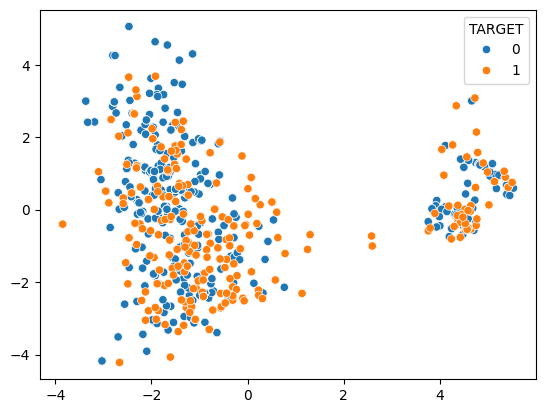

In [59]:
sns.scatterplot(x=d2_data[:, 0], y=d2_data[:, 1], hue=y_fin)
plt.show()
# BASELINE + OPTUNA

In [61]:
len(X_fin)

1510

In [60]:
y_fin.mean()

np.float64(0.2)

# DISTRIBUTION ANALYSIS

In [74]:
y_fin.value_counts(normalize=True).mul(100).round(2)

TARGET
0    80.0
1    20.0
Name: proportion, dtype: float64

In [75]:
for col in X_fin.columns:
    print(col)
    print(X_fin[col].value_counts(normalize=True).mul(100).round(2))
    print('\n')
    

CNT_CHILDREN
CNT_CHILDREN
0    66.95
1    24.11
2     7.02
3     1.52
4     0.40
Name: proportion, dtype: float64


AMT_INCOME_TOTAL
AMT_INCOME_TOTAL
112500    22.45
135000    20.99
180000    16.62
202500    13.44
157500     8.94
225000     7.09
315000     1.39
90000      1.06
108000     0.73
270000     0.66
450000     0.66
67500      0.60
162000     0.53
126000     0.40
99000      0.33
306000     0.33
247500     0.33
103500     0.26
76500      0.26
391500     0.20
121500     0.20
360000     0.13
292500     0.13
540000     0.13
238500     0.13
81000      0.13
256500     0.13
171000     0.13
216000     0.13
130500     0.13
585000     0.13
472500     0.07
337500     0.07
72900      0.07
65250      0.07
215550     0.07
215100     0.07
85500      0.07
207000     0.07
36000      0.07
675000     0.07
459000     0.07
405000     0.07
72000      0.07
211500     0.07
148500     0.07
45000      0.07
195750     0.07
56250      0.07
Name: proportion, dtype: float64


DAYS_BIRTH
DAYS_BIRTH
13797    

# BASELINE MODEL LOGREG

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_fin, y_fin, test_size=0.4, random_state=42, stratify=y_fin, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test, shuffle=True)

In [67]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [68]:
base_linear_model = LogisticRegression(max_iter=1000, class_weight='balanced')
base_linear_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [69]:
base_linear_model.score(X_test, y_test)

0.8178807947019867

In [70]:
roc_auc_score(y_test, base_linear_model.predict_proba(X_test)[:, 1])

0.8165977961432507

In [71]:
average_precision_score(y_test, base_linear_model.predict_proba(X_test)[:, 1])

0.6936812997324947

In [72]:
f1_score(y_test, base_linear_model.predict(X_test))

0.5925925925925926

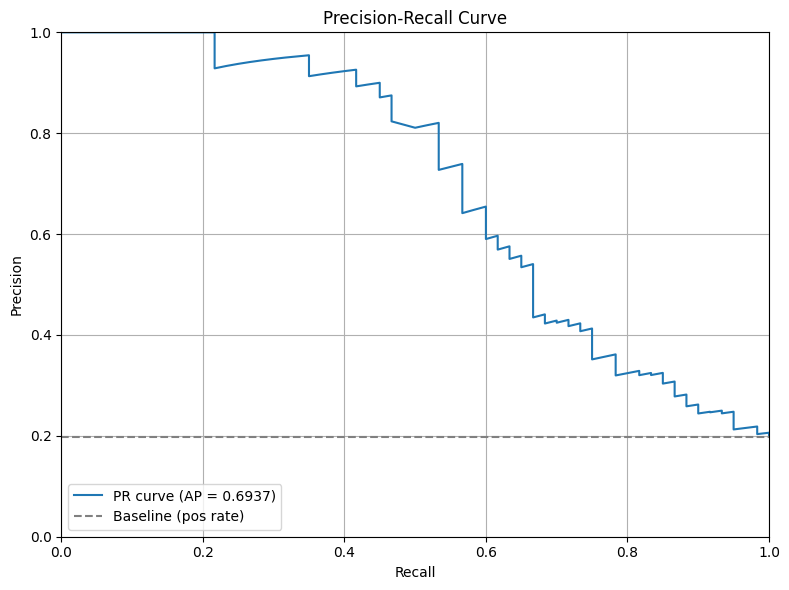

In [73]:
probas = base_linear_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (pos rate)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

**Вывод**: Логистическая регрессия показала неплохо, ROC-AUC выше 0.8. Учитывая баланс классов это неплохой результат. PR-AUC при этом ниже почти равен 0.7, что является удовлетворительным показателем, но недостаточно хорошим для продовой версии.

# BASELINE MODEL CATBOOST

In [76]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [77]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_fin, y_fin, test_size=0.4, random_state=42, stratify=y_fin, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test, shuffle=True)

In [96]:
base_catboost_model = CatBoostClassifier(custom_metric=['AUC', 'F1', 'Recall', 'Precision', 'PRAUC'], task_type='GPU')
base_catboost_model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [97]:
roc_auc_score(y_test, base_catboost_model.predict_proba(X_test)[:, 1])

0.9789600550964187

In [98]:
average_precision_score(y_test, base_catboost_model.predict_proba(X_test)[:, 1])

0.9423310138197165

In [99]:
f1_score(y_test, base_catboost_model.predict(X_test))

0.8392857142857143

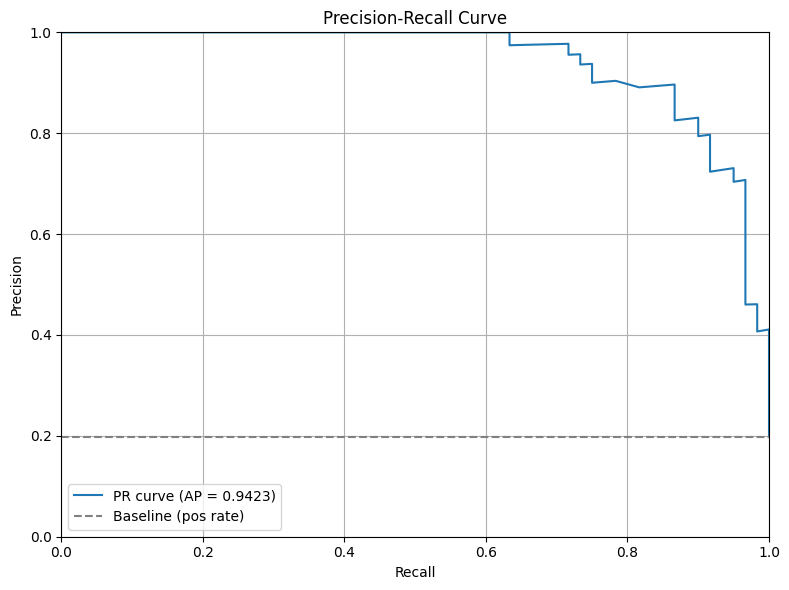

In [100]:
# Precision-Recall curve visualization
probas = base_catboost_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (pos rate)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

**Вывод**: Катбуст улавливает больше нелинейных взаимосвязей и показывает намного лучше резултаты, чем логистическая регрессия по целевым метриками. ROC-AUC выше 0.9, при этом PR-AUC тоже стал выше 0.9, что удовлетворяет условию продовой модели. Попробуем перебрать гиперпараметры или сбалансировать классы, чтобы еще улучшить модель.

# BASELINE MODEL CATBOOST + CLASS BALANCE

In [84]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_fin, y_fin, test_size=0.4, random_state=42, stratify=y_fin, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test, shuffle=True)

In [85]:
from catboost import CatBoostClassifier

In [86]:
balanced_catboost_model = CatBoostClassifier(
    custom_metric=['AUC', 'F1', 'Recall', 'Precision', 'PRAUC'], 
    task_type='GPU',
    auto_class_weights='Balanced'
    )
balanced_catboost_model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [87]:
roc_auc_score(y_test, balanced_catboost_model.predict_proba(X_test)[:, 1])

0.9855027548209366

In [88]:
average_precision_score(y_test, balanced_catboost_model.predict_proba(X_test)[:, 1])

0.9465973426998738

In [89]:
f1_score(y_test, balanced_catboost_model.predict(X_test))

0.8717948717948718

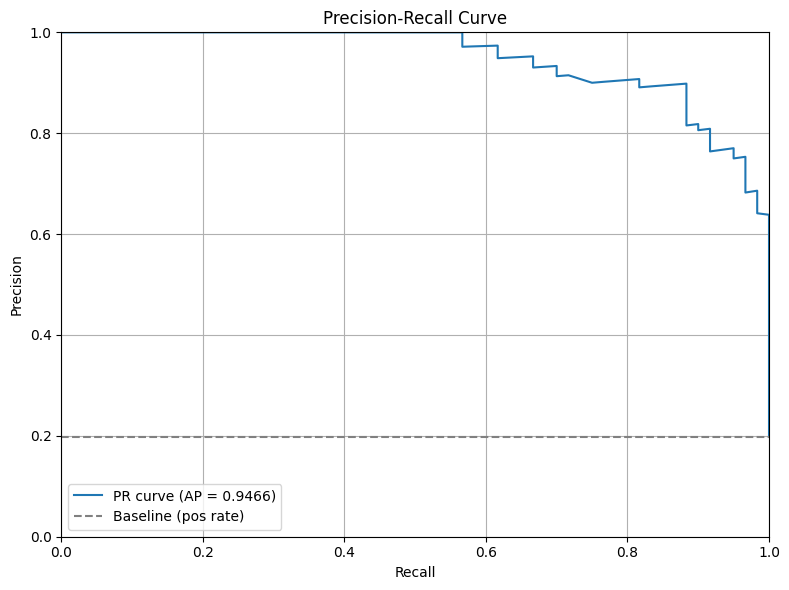

In [90]:
# Precision-Recall curve visualization
probas = balanced_catboost_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (pos rate)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

In [91]:
sqrt_balanced_catboost_model = CatBoostClassifier(
    custom_metric=['AUC', 'F1', 'Recall', 'Precision', 'PRAUC'], 
    task_type='GPU',
    auto_class_weights='SqrtBalanced'
    )
sqrt_balanced_catboost_model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [92]:
roc_auc_score(y_test, sqrt_balanced_catboost_model.predict_proba(X_test)[:, 1])

0.9756542699724517

In [93]:
average_precision_score(y_test, sqrt_balanced_catboost_model.predict_proba(X_test)[:, 1])

0.9343693034481254

In [94]:
f1_score(y_test, sqrt_balanced_catboost_model.predict(X_test))

0.8421052631578947

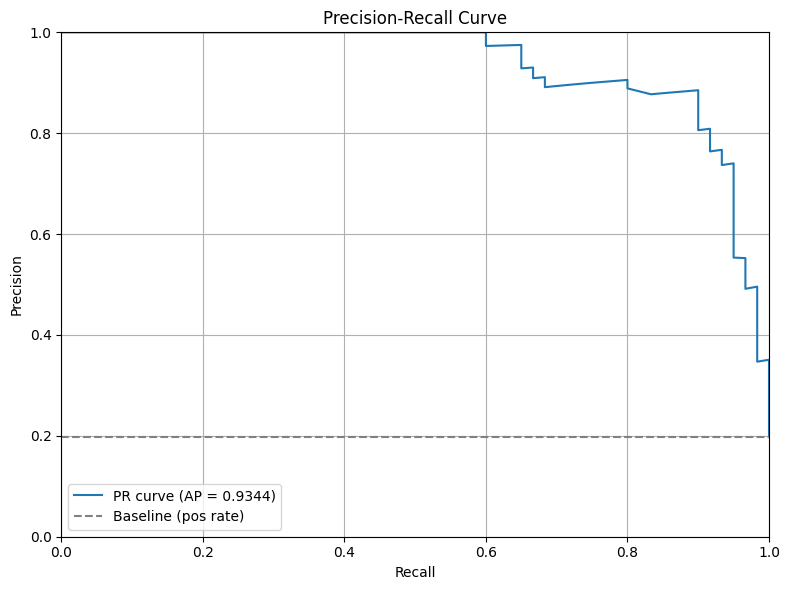

In [95]:
# Precision-Recall curve visualization
probas = sqrt_balanced_catboost_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (pos rate)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

**Вывод**: Балансировка классов Balanced и SqrtBalanced почти не повлияли на результат. Но среди полученных, Balanced показал улучшение по сравнению с бэйзлайном по всем метрикам. По F1 более значимо. Пробуем перебирать гиперпараметры в том числе и переберем pos_scale_weight для более точной настройки балансировки.

# BASELINE + OPTUNA

In [102]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)


def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 2000, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 5.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 5.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 32),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.0, 10.0),
    }

    model = CatBoostClassifier(
        **params,
        task_type='GPU',
        eval_metric='PRAUC',
        custom_metric=['AUC', 'F1', 'Recall', 'Precision', 'PRAUC'],
        random_seed=42,
    )

    model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        use_best_model=True,
        early_stopping_rounds=100,
        verbose=False,
        plot=False,
    )

    preds = model.predict_proba(X_test)[:, 1]
    pr_auc = average_precision_score(y_test, preds)
    trial.set_user_attr('best_iteration', model.get_best_iteration())
    trial.set_user_attr('model', model)
    return pr_auc

X_train, X_val_test, y_train, y_val_test = train_test_split(X_fin, y_fin, test_size=0.4, random_state=42, stratify=y_fin, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test, shuffle=True)

study = optuna.create_study(direction='maximize', study_name='catboost_pr_auc')
study.optimize(objective, n_trials=20, timeout=3600, show_progress_bar=True)

print(f'Best PR-AUC: {study.best_value:.5f}')
print('Best parameters:')
for key, value in study.best_params.items():
    print(f'  {key}: {value}')

  0%|          | 0/20 [00:00<?, ?it/s]

Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented

Best PR-AUC: 0.96260
Best parameters:
  iterations: 1248
  depth: 8
  learning_rate: 0.00362571628871486
  l2_leaf_reg: 0.02191614165629933
  bagging_temperature: 1.762994909675063
  random_strength: 0.7008344641321657
  border_count: 150
  grow_policy: Depthwise
  min_data_in_leaf: 6
  scale_pos_weight: 4.4696290960989735


In [103]:
best_model = study.best_trial.user_attrs['model']

In [104]:
study.best_trial.user_attrs['model'].save_model('models/optuna_nearmiss_model.cbm')

In [105]:
roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

0.9862947658402204

In [106]:
f1_score(y_test, best_model.predict(X_test))

0.8888888888888888

In [ ]:
average_precision_score(y_test, best_model.predict_proba(X_test)[:, 1])

0.9626019322114513

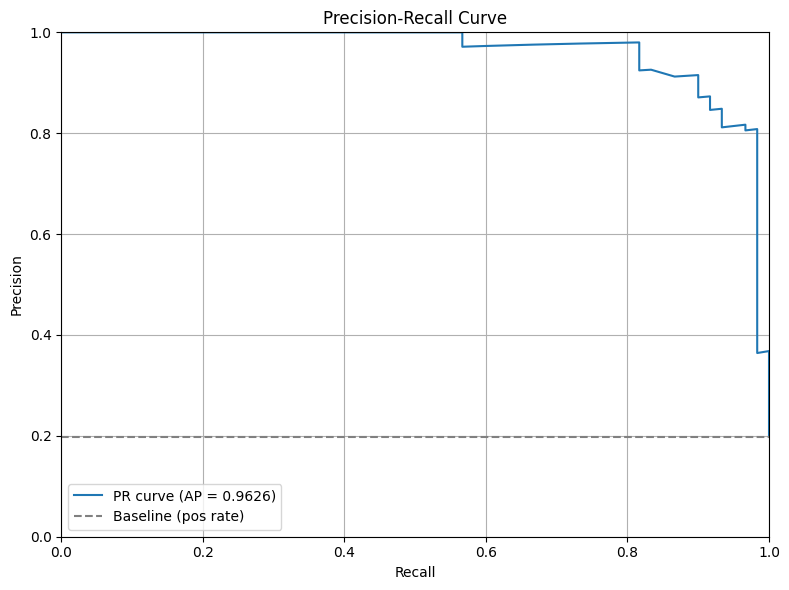

In [108]:
# Precision-Recall curve visualization
probas = best_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (pos rate)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

**Вывод**: После перебора гиперпараметров PR-AUC стал еще выше. Берем эту версию для дальнейшего использование в продакшене. Параметры итоговой модели:
ROC-AUC = 98.63
PR-AUC = 96.26
F1 = 88.89

In [109]:
from sklearn.metrics import classification_report
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       242
           1       0.91      0.87      0.89        60

    accuracy                           0.96       302
   macro avg       0.94      0.92      0.93       302
weighted avg       0.96      0.96      0.96       302

